Alexander Simmons 02/23/2026

N-Bodies Gravitation Simulation
---

Goal: To create a simulator capable of modeling gravitational motion with $N$ bodies.

INTRODUCTION
---
All future calculations rely on one of the core principles of mechanical physics, Gravitation.
$$
\vec{F} = G\frac{m_1 m_2}{r^2}
$$
As defined by Ohanian & Markert, "gravitation is a mutual attraction between all masses."$^1$ Displayed by the above function, the magnitude of gravitation, or that mutual attraction, is proportional to the product of both masses and inversely proportional to the square of the distance between the centers of mass of the two bodies. As a result of this relationship, an experiment of two small masses of one $kg$ with a one meter separation would result in an immensely tiny gravitational force between the bodies. Hereby, a simulator gives an opportunity to apply fundamental physics in scenarios much too large for practical experimental use. 

It is standard to define values that will be used as reference for the rest of the project; hence, masses will be computed as a ratio of true mass in $kg$ to the Sun's true mass in $kg$. The masses most important for the first section of this project are the Sun's and the Earth's. All values of mass in $kg$ are determined from nasa.gov and are used to compute the gravitational forces between celestial bodies. 
$$
m_{sun} = \frac{M_{sun}}{M_{sun}} = 1
$$
$$
m_{earth} = \frac{M_{earth}}{M_{sun}} = \frac{5.972\times10^{24} kg}{1.988\times10^{30} kg} = 3.003\times10^{-6}
$$
Thus, the mass of the sun is $1$ and the earth's $3.003\times10^{-6}$. Now that the masses have been defined, we choose simulation units such that the gravitational constant $G = 1$.
$$
\vec{F} = G\frac{m_{sun} m_{earth}}{r_{sun,earth}^2} = (1)\frac{(1) (3.003\times10^{-6})}{(1)^2} = 3.003\times10^{-6}
$$
Having $G$ as $1$ both normalizes the system and enables the data to scale sustainably when we implement more bodies. 

POSITION
---
$$
\vec{r}_{sun} = (0, 0)
$$
$$
\vec{r}_{earth} = (1, 0)
$$
$$
|\vec{r}_{earth}-\vec{pos}_{sun}| = 1
$$
Additional normalization includes defining the Earth–Sun separation as our unit distance. This distance is traditionally referred to as 1 AU; however, the distance unit is absorbed into the normalization. The Sun is defined as the origin of the coordinate system, and the Earth is set 1 unit in the positive $x$-direction from the origin.

VELOCITY
---

Velocity of the celestial bodies is significant for this project as determining each object's motion over time is one of the outcomes necessary to model how each body affects each other body. 

Circular orbital speed can be defined as follows.
$$
v_{circ} = \sqrt{\frac{GM}{r}}
$$
Applying this formula on the Earth shows that the Earth is traveling in the positive $y$-direction with unit speed. 
$$
v_{circ} = \sqrt{\frac{(1)(1)}{1}} = 1
$$
$$
\vec{v}_{earth} = (0, v_{circ}) = (0, 1)
$$
Since the system is circular in motion, the velocity vector is tangental to the radius vector. As defined previously, the earth is at 1 unit on the positive $x$-axis and 0 units on the $y$-axis. 
A tangential velocity to the radius vector aligns with the found vector (0, 1).
$$
\vec{v}_{sun} = -\frac{m_{earth}}{m_{sun}}\vec{v}_{earth}
$$
$$
\vec{v}_{sun} = -\frac{3.003\times10^{-6}}{1}(1) = (0, -3.003\times10^{-6}) 
$$
Note the Sun is not entirely stationary. This motion results in a slight deviation from a perfectly circular orbit.

CODE
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#Defining Values
m_earth = 3.003e-6 
m_sun = 1.0
G = 1

pos_sun = [0, 0]
pos_earth = [1, 0]
r = 1 

vel_earth = [0, 1]
vel_sun = [0, 0]

# Initialize arrays for Mass, Position, and Velocity
# Uses float for 64-bit precision
m = np.array([m_sun, m_earth], dtype=float)
pos = np.array([pos_sun, pos_earth], dtype=float)
vel = np.array([vel_sun, vel_earth], dtype=float)

# re-define Sun's initial velocity as calculated value
vel[0] = -(m[1] / m[0]) * vel[1]

Here we setup arrays for masses, position, and velocity. Position and velocity change over time, whereas the mass remains constant.

In [2]:
def accelerations(pos, m, G=1.0, eps=1e-3):
    """
    pos: (N,2)
    m:   (N,)
    returns acc: (N,2)
    eps: softening term for near 0 distances
    """
    N = pos.shape[0]
    acc = np.zeros_like(pos)

    for i in range(N):
        for j in range(N):
            if i == j:
                continue
            r_vec = pos[j] - pos[i]                 # vector from i -> j
            r2 = np.dot(r_vec, r_vec) + eps**2      # softened r^2
            inv_r3 = 1.0 / (r2 * np.sqrt(r2))       # 1 / r^3
            acc[i] += G * m[j] * r_vec * inv_r3     # a_i += G m_j r_vec / r^3

    return acc

Acceleration
---

The gravitational acceleration of body $i$ is given by
$$
\vec{a}_i = G \sum_{j\neq{i}}m_j\frac{\vec{r}_j-\vec{r}_i}{|\vec{r}_j-\vec{r}_i|^3} = G \sum_{j\neq{i}}m_j\frac{\vec{r}_j-\vec{r}_i}{(|\vec{r}_j-\vec{r}_i|^2 + \varepsilon^2)^{3/2}} 
$$
This formula computes the gravitational acceleration on each body. Everything in the above code block is an implementation of this.
In the calculation of $r^2_{ij}$, eps ($\varepsilon$) is used as a softening term to prevent singularities when bodies pass very close to one another. 
Beginning in the first '#' commented line,
$$
\vec{r}_{ij} = \vec{r}_j - \vec{r}_i
$$
Then, we compute the value of $r^2_{ij}$
$$
r^2_{ij} = \vec{r}_{ij} \cdot \vec{r}_{ij} + \varepsilon^2
$$
Using the softened $r^2_{ij}$ we find the denominator
$$
\frac{1}{r^3_{ij}} = \frac{1}{r^2_{ij} * \sqrt{r^2_{ij}}} = \frac{1}{(r^2_{ij})^{3/2}} 
$$
Lastly we are able to calculate acceleration
$$
\vec{a}_i = Gm_j\frac{\vec{r}_{ij}}{r^3_{ij}}
$$
This process is repeated for each body until acceleration is determined for body $i$. This step is used to calculate the acceleration for all $N$ bodies in the system.

In [3]:
def step_velocity_verlet(pos, vel, m, dt, G=1.0, eps=1e-3):
    a = accelerations(pos, m, G=G, eps=eps)
    pos_new = pos + vel * dt + 0.5 * a * dt**2 # kinematic equation
    a_new = accelerations(pos_new, m, G=G, eps=eps)
    vel_new = vel + 0.5 * (a + a_new) * dt # kinematic equation
    return pos_new, vel_new

CALCULATIONS
---
Ths step_velocity_verlet procedure calculates the net acceleration on the body, then finds the new position using the input $v_o$, $\vec{a}$, and time step $dt$. From there, the new position is used to calculate the new acceleration because acceleration is inversely proportional to the distance between the center of the masses of the bodies squared. Acceleration's magnitude should be roughly constant given the two body, near circular motion system.
$$
\vec{r}_{new} = \vec{r}_o + v_ot + \frac{1}{2}\vec{a}{dt}^2
$$
Using this new position, the acceleration is calcuated with respect to the new distance. From there a second kinematic equation is used to calculate velocity.
$$
\vec{v}_{new} = \vec{v}_o + \frac{1}{2}(\vec{a} + \vec{a}_{new})dt
$$
These values are then returned and stored to pos_sim and vel_sim.


In [4]:
dt = 0.001
steps = 6283  # one orbit is ~2π ≈ 6.28, given unit circle it takes 2π time to make a full loop

traj_earth = np.zeros((steps, 2))
traj_sun = np.zeros((steps, 2))

pos_sim = pos.copy()
vel_sim = vel.copy()

for k in range(steps):
    traj_sun[k] = pos_sim[0]
    traj_earth[k] = pos_sim[1]
    pos_sim, vel_sim = step_velocity_verlet(pos_sim, vel_sim, m, dt, G=G, eps=1e-3)

As seen here, each step we take the current position, velocity, and calculate a new position and velocity to use for the beginning of the next step. The time step $dt = 0.001$, so each step advances the simulation by 0.001 units of time. For motion around a unit circle $(r = 1)$ with speed of $(v = 1)$, one full revolution takes 2 $\pi$ time. Therefore, to calculate steps we use
$$
t_{rev} = \frac{\text{circumference}}{v} = \frac{2\pi r}{v} = 2\pi \text{ for unit circle.}
$$
$$
\frac{2\pi}{0.001} \approx 6283 \text{ steps.}
$$
A limitation that comes up is we are truncating $2 \pi$ which means that a full orbital is not completed as we're missing roughly 0.000185 units of time. If $dt$ is augmented, less steps need to be taken which reduces run time, but it decreases the accuracy of the calculations. Inversely, if $dt$ is made smaller, more steps need to be taken, increasing the accuracy of the simulation and total run time.

![N-body animation](images/SunEarth.gif)

In gravitational motion with two bodies, the barycenter is the center of mass in the system. The barycenter can be found by calculating
$$
\vec{r}_{cm} = \frac{m_{sun}\vec{r}_{sun} + m_{earth}\vec{r}_{earth}}{m_{sun}+m_{earth}} 
$$

As presented by the graphs, both entities orbit the system's barycenter in a counterclockwise motion. Due to the Earth's gravitational forces exerted upon the Sun, the Sun wobbles around the barycenter. Since the mass of the Sun is proportionally much larger than that of the Earth this wobble is significantly smaller in magnitude than the Earth's orbit. Notably the scale of the Sun's orbit is on the order of $10^{-6}$ smaller than the Earth's.

Now that we've examined gravitational motion between two bodies, the Earth and the Sun, it's time to consider gravitational motion for $N$ bodies.

$N$-bodies Gravitation Simulation
---
Similar to two bodies, we will calculate the net acceleration of the object by outside forces, then show how it changes over time with respect to each other body in the system. For the purposes of this simulation a $N = 15$ bodies will be generated with a minimum distance of 20 units, and a set seed will be used for replication of the random data. Additionally, a seedless variant will be included at the end of this notebook for use of any readers to get the sense of how gravitational motion varies with distance and mass.

Here is a simulated gravitational motion of 15 bodies, enjoy.

C:\Users\lexsi\AppData\Local\Temp\ipykernel_20608\188667947.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


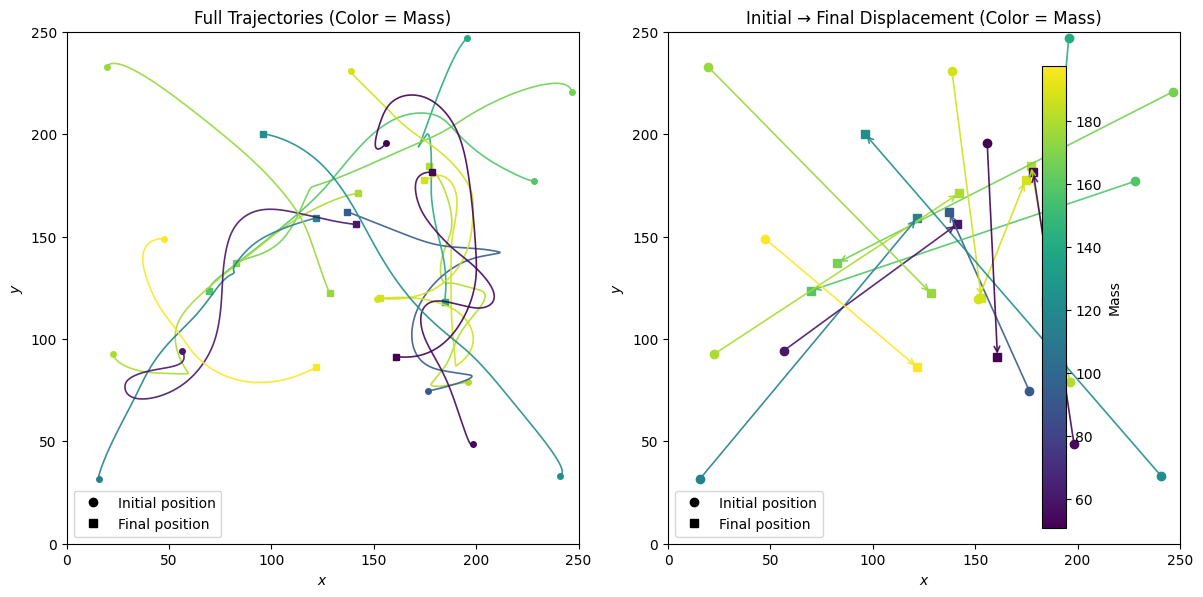

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Defines the random generation of bodies | seed arbitrarily chosen as 9
# If in 200,000 attempts it cannot generate a possible system then program crashes.
def init_nbody(N, bounds=(0, 250), min_dist=20.0, mass_range=(50, 200),
               speed_scale=8.0, seed=9, max_tries=200_000):
    lo, hi = bounds
    rng = np.random.default_rng(seed)
    m = rng.uniform(*mass_range, N)

    pos = np.empty((N, 2), float)
    d2min = min_dist**2
    k = t = 0
    while k < N:
        t += 1
        if t > max_tries:
            raise RuntimeError("Placement failed: reduce N/min_dist or increase bounds.")
        c = rng.uniform(lo, hi, 2)
        if k == 0 or np.all(np.sum((pos[:k] - c)**2, axis=1) >= d2min):
            pos[k] = c
            k += 1

    vel = rng.normal(0.0, speed_scale, (N, 2))
    vel -= (m[:, None] * vel).sum(axis=0) / m.sum()  # remove net momentum
    return pos, vel, m

# Optimized version of acceleration calculation. Note G=150.0, eps = 10.0
def accel(pos, m, G=150.0, eps=10.0):
    r = pos[None, :, :] - pos[:, None, :]                  # (N,N,2)
    d2 = np.sum(r*r, axis=2) + eps**2                      # (N,N)
    np.fill_diagonal(d2, np.inf)
    inv_d3 = 1.0 / (d2 * np.sqrt(d2))                      # (N,N)
    return G * np.sum(r * inv_d3[:, :, None] * m[None, :, None], axis=1)  # (N,2)

# Bulk of the simulation, it takes 5000 steps of 0.001. Note G=150.0, eps = 10.0
def simulate(pos, vel, m, steps=5000, dt=0.001, G=150.0, eps=10.0):
    N = pos.shape[0]
    traj = np.empty((steps + 1, N, 2), float)
    traj[0] = pos
    a = accel(pos, m, G, eps)
    for k in range(1, steps + 1):
        pos = pos + vel*dt + 0.5*a*dt*dt
        a2 = accel(pos, m, G, eps)
        vel = vel + 0.5*(a + a2)*dt
        a = a2
        traj[k] = pos
    return traj

# -----------------------
# Run simulation
# -----------------------
N, steps, dt = 15, 5000, 0.001
pos0, vel0, m = init_nbody(
    N, bounds=(0, 250), min_dist=20.0, mass_range=(50, 200),
    speed_scale=8.0, seed=9
)
traj = simulate(pos0, vel0, m, steps=steps, dt=dt, G=150.0, eps=10.0)

# -----------------------
# Dual plot (mass-colored) - no tight_layout warning
# -----------------------
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

# Color bodies by mass (light -> heavy) + colorbar
norm = plt.Normalize(m.min(), m.max())
cmap = plt.cm.viridis
colors = cmap(norm(m))  # (N,4)

sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
fig.colorbar(sm, ax=[ax0, ax1], label="Mass")

# --- LEFT: full trajectories ---
ax0.plot([], [], 'o', color='black', label='Initial position')
ax0.plot([], [], 's', color='black', label='Final position')

for i, c in enumerate(colors):
    x, y = traj[:, i, 0], traj[:, i, 1]
    ax0.plot(x, y, color=c, lw=1.2, alpha=0.9)
    ax0.plot([x[0]], [y[0]], 'o', color=c, ms=4)
    ax0.plot([x[-1]], [y[-1]], 's', color=c, ms=4)

ax0.set(aspect='equal', xlim=(0, 250), ylim=(0, 250),
        xlabel=r"$x$", ylabel=r"$y$",
        title="Full Trajectories (Color = Mass)")
ax0.legend()

# --- RIGHT: initial vs final with arrows ---
ax1.plot([], [], 'o', color='black', label='Initial position')
ax1.plot([], [], 's', color='black', label='Final position')

for i, c in enumerate(colors):
    xi, yi = traj[0, i, 0], traj[0, i, 1]
    xf, yf = traj[-1, i, 0], traj[-1, i, 1]

    ax1.plot([xi], [yi], 'o', color=c, ms=6)
    ax1.plot([xf], [yf], 's', color=c, ms=6)

    ax1.annotate(
        '',
        xy=(xf, yf),
        xytext=(xi, yi),
        arrowprops=dict(arrowstyle='->', color=c, lw=1.2, alpha=0.9)
    )

ax1.set(aspect='equal', xlim=(0, 250), ylim=(0, 250),
        xlabel=r"$x$", ylabel=r"$y$",
        title="Initial → Final Displacement (Color = Mass)")
ax1.legend()

plt.show()

![N-body animation](images/nbody_animation.gif)

Analysis
---
more to come soon!